In [1]:
import sys
import os

# Add repo root to Python path (one level up from examples/)
sys.path.append(os.path.abspath(".."))  

from src.parsing import *
from src.inference import *
from CRN_Simulation.CRN import CRN

import numpy as np
import random

In [2]:
# Potentially make something that would generate all the complexes and such.
# Could generalize more.

# Define species names
species_names = ["X", "Y", "Z"]

# Define complexes (example: bi-molecular); Dimension is # species x # complexes
complexes = np.array([
    [0, 1, 0, 0, 2, 0, 0, 1, 1, 0],
    [0, 0, 1, 0, 0, 2, 0, 1, 0, 1],
    [0, 0, 0, 1, 0, 0, 2, 0, 1, 1]
])


# Create Reactant, Product, Stochiometric Matrix, Define Compatible Reactions and Everything Needed for CRN
reactant_matrix, product_matrix, stoichiometric_matrix, reaction_names, parameter_names, compatible_reactions = generate_reactions(complexes, species_names)

# Plot some output to the screen
print(f"Total reactions generated: {len(reaction_names)}")
max_show = 3
print("Some Reaction Names:", reaction_names[:max_show])

print("Some Non-Unique Stoichiometric Changes")
count_shown = 0
for deltaX, rxn_indices in compatible_reactions.items():
    if len(rxn_indices) > 1:
        deltaX_clean = tuple(int(x) for x in deltaX)
        # Grab all reaction names
        rxn_names = [reaction_names[i] for i in rxn_indices]
        print(f"ΔX = {deltaX_clean} → indices: {rxn_indices}, reactions: {rxn_names}")
        count_shown += 1
        if count_shown >= max_show:
            break

Total reactions generated: 90
Some Reaction Names: ['Empty_to_X:', 'Empty_to_Y:', 'Empty_to_Z:']
Some Non-Unique Stoichiometric Changes
ΔX = (1, 0, 0) → indices: [0, 12, 24, 34], reactions: ['Empty_to_X:', 'X_to_2X:', 'Y_to_X+Y:', 'Z_to_X+Z:']
ΔX = (0, 1, 0) → indices: [1, 15, 22, 35], reactions: ['Empty_to_Y:', 'X_to_X+Y:', 'Y_to_2Y:', 'Z_to_Y+Z:']
ΔX = (0, 0, 1) → indices: [2, 16, 26, 32], reactions: ['Empty_to_Z:', 'X_to_X+Z:', 'Y_to_Y+Z:', 'Z_to_2Z:']


In [3]:
# Number of Reactino to Sample and Gamma Prior
N = 3
alpha, beta = 2.6, 0.4

# Build CRN Required components by Sampling
(CRN_stoichiometric_matrix, CRN_reaction_names, CRN_parameter_names,
 CRN_propensities, trueTheta, parameter_values, sampled_indices) = build_CRN_bySamplingReactions(
    reactant_matrix, product_matrix, stoichiometric_matrix,
    reaction_names, parameter_names,
    species_names=species_names,
    N=N, alpha=alpha, beta=beta, seed=42, verbose = True)

# Create Reaction Network with CRN_Simulation.CRN
reactionNetwork = CRN(species_names=species_names,
         stoichiometric_matrix=CRN_stoichiometric_matrix,
         parameters_names=CRN_parameter_names,
         reaction_names=CRN_reaction_names,
         propensities=CRN_propensities)


Sampling 3 reactions out of 90 total reactions in the CRN.

Index Param  Reaction Name             Value   
--------------------------------------------------
81    k81    Y+Z_to_Empty:             1.240   
14    k14    X_to_2Z:                  0.826   
3     k3     Empty_to_2X:              0.773   

Full trueTheta vector (length 90):


Initial state: {'X': 7, 'Y': 4, 'Z': 8}
Trajectory saved to ../data/example3_trajectory.json


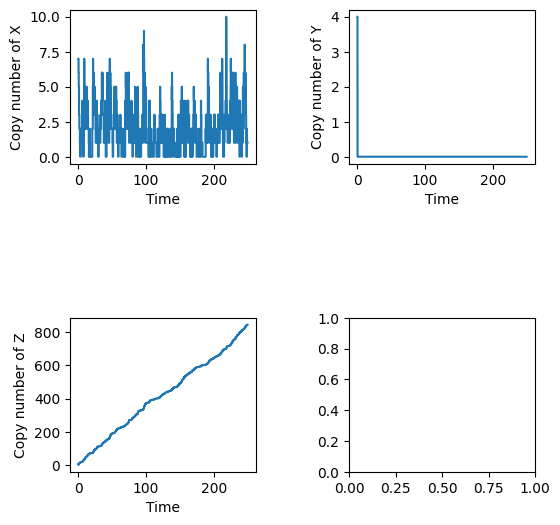

In [4]:
data_dir = "../data"  # relative to examples/ folder
os.makedirs(data_dir, exist_ok=True)

# Generate trajectory
time_list, state_list = generate_single_trajectory(
    reactionNetwork,
    parameter_values,
    species_names,
    finalTime=250,   # adjust as needed
    minVal=1,
    maxVal=10,
    seed=42          # for reproducibility
)

# Save trajectory to JSON
trajectory_file = os.path.join(data_dir, "example3_trajectory.json")
save_trajectory(time_list, state_list, filename=trajectory_file)

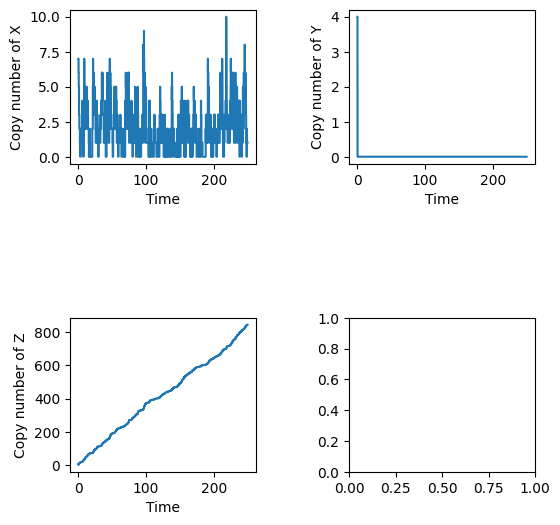

In [5]:
trajectory_file_new = "../data/example3_trajectory.json"
time_list_new, state_list_new = load_trajectory(trajectory_file_new)
reactionNetwork.plot_trajectories(time_list, state_list)

In [6]:
# Parse trajectories for CRN1
print("Parsing Trajectory 1")
unique_changes, unique_states, jump_counts, waiting_times, propensities = parse_trajectory(
    state_list,time_list,reactant_matrix,compatible_reactions,verbose=True)
print("---------")

# Parse trajectories for CRN1
print("Parsing Trajectory 2")
unique_changes, unique_states_new, jump_counts_new, waiting_times_new, propensities_new = parse_trajectory(
    state_list_new,time_list_new,reactant_matrix,compatible_reactions,verbose=True)
print("---------")

# Print basic summary
print("Finished parsing trajectories. Summary:")
print(f"Trajectory 1: {len(unique_states)} unique states observed")
print(f"Trajectory 2: {len(unique_states_new)} unique states observed")

Parsing Trajectory 1
Tracking 54 unique stoichiometric changes (single trajectory).
Trajectory length: 633 timepoints.  Will iterate to len-2 to avoid final non-jump.
Finished parsing single trajectory. Observed 631 unique states.
---------
Parsing Trajectory 2
Tracking 54 unique stoichiometric changes (single trajectory).
Trajectory length: 633 timepoints.  Will iterate to len-2 to avoid final non-jump.
Finished parsing single trajectory. Observed 631 unique states.
---------
Finished parsing trajectories. Summary:
Trajectory 1: 631 unique states observed
Trajectory 2: 631 unique states observed


Extracting local data for stoichiometric change [2, 0, 0] at index 3
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 631 states processed.
Total observed jumps for this local stoichiometric change: 207
Local True Theta = [0.77283931]
Log-Likelihood at True Theta = -143.9583685633368
Maximum Log-Likelihood = -91.09465457542652
Best Multiplier = 2.0
Best Theta = [1.54567861]


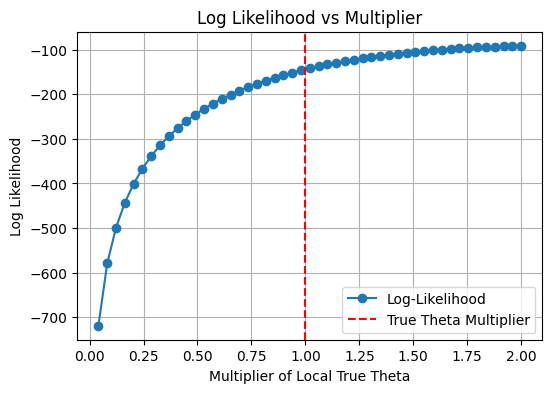

In [13]:
# Local Likelihood Exploration for CRN1

pos_indices, pos_deltaX = get_positive_deltaX_indices_and_values(jump_counts, unique_changes)

indexToCheck = pos_indices[0]
deltaXToCheck = pos_deltaX[0]

#Extract the local data for the desired stochiometric change.
(local_counts, local_waiting_times, local_propensities, selected_deltaX) = extract_local_data(
    jump_counts, waiting_times, propensities, unique_changes, 
    index=indexToCheck, deltaX=deltaXToCheck, verbose=True)

#Extract the Local True Theta for the unique stochiometric change
localTheta = trueTheta[compatible_reactions[selected_deltaX]]

multipliers, ll_values, max_ll, best_multiplier, best_theta = plot_likelihood_vs_theta_multiplier(
    local_counts,
    local_waiting_times,
    local_propensities,
    localTheta,
    delta=1,
    num_points=50,
    title='Log Likelihood vs Multiplier'
)

Hmm - we should really be doing better here. We should take a look at the likelihood calculation to make sure things aren't off.